In [2]:
# from tensorflow.keras.models import load_model

# # Provide the path to your model
# model_path = '/home/jovyan/shared/jiarui-notebooks/efficientnet_2020_2023.keras'

# # Load the model
# model = load_model(model_path)

In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

import seaborn as sns
from matplotlib import pyplot as plt

2023-08-10 15:53:48.670792: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 15:53:48.720573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 15:53:48.721793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 15:53:49.482390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds = xr.open_dataset('/home/jovyan/shared/data/finalized/sst.nc')

ds['time'] = ds['time'].dt.floor('D')

zarr_new = ds.sel(lat=slice(35, -5), lon=slice(45,90))

all_nan_dates = np.isnan(zarr_new["sst"]).all(dim=["lon", "lat"]).compute()

zarr_ds = zarr_new.sel(time=all_nan_dates == False)

zarr_ds = zarr_ds.sortby('time')

zarr_ds

<xarray.Dataset>
Dimensions:  (time: 7671, lat: 149, lon: 181)
Coordinates:
  * lon      (lon) float32 45.0 45.25 45.5 45.75 46.0 ... 89.25 89.5 89.75 90.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 31.0 ... -4.25 -4.5 -4.75 -5.0
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables:
    sst      (time, lat, lon) float32 nan nan nan nan ... 301.2 301.2 301.1
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

In [3]:
def create_data_map(variable_name, start_date='2000-01-01', end_date='2020-12-31'):
    date_range = pd.date_range(start=start_date, end=end_date)

    zarr_dates = pd.to_datetime(zarr_new.time.values)

    # times we don't have labels
    skip_ranges = [
        pd.date_range(start='1983-04-01', end='1983-04-30'),
        pd.date_range(start='1988-02-01', end='1988-02-29'),  # February in a leap year
        pd.date_range(start='1992-09-01', end='1992-09-30'),
        pd.date_range(start='1997-02-01', end='1997-02-28'),
        pd.date_range(start='2001-11-01', end='2001-11-30'),
        pd.date_range(start='2006-04-01', end='2006-04-30'),
        pd.date_range(start='2011-02-01', end='2011-02-28'),
        pd.date_range(start='2015-06-01', end='2015-06-30'),
        pd.date_range(start='2020-02-01', end='2020-02-29')  # February in a leap year
    ]

    date_to_data_map = {}

    for date in date_range:
        if any(date in skip_range for skip_range in skip_ranges):
            continue
        if date in zarr_dates:
            data = getattr(zarr_new, variable_name).sel(time=str(date.date())).values
            if not np.all(np.isnan(data)):
                mean_val = np.nanmean(data)
                normalized_day_data = data - mean_val
                normalized_day_data = np.nan_to_num(normalized_day_data, nan=0.0)

                date_to_data_map[date] = normalized_day_data

    return date_to_data_map

data_map = create_data_map('sst')

In [4]:
sample_data = next(iter(data_map.values()))
input_shape = (sample_data.shape[0], sample_data.shape[1], 1)
input_shape

(149, 181, 1)

In [5]:
def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month

        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('2000-01-01', '2020-12-31')

Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200001_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200002_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200003_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200004_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200005_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200006_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200007_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200008_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200009_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/200010_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0

In [6]:
valid_dates = list(data_map.keys())
filtered_labels = labels[labels.index.isin(valid_dates)]

assert len(data_map) == len(filtered_labels)

In [7]:
all_labels_reshaped = filtered_labels.values.ravel()

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

X = np.array(list(data_map.values()))

X = np.expand_dims(X, axis=-1)

# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X, all_labels_reshaped, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 for validation

sample_data = next(iter(data_map.values()))
input_shape = (sample_data.shape[0], sample_data.shape[1], 1)

base_model = EfficientNetB0(include_top=False, weights=None, input_shape=input_shape)

# Add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
# And a logistic layer
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tqdm_callback = TqdmCallback(verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[tqdm_callback, early_stopping_callback], validation_split=0.1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

48/48 [==============================] - 9s 195ms/step - loss: 0.0818 - accuracy: 0.9787
Accuracy: 0.9787375330924988


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step
[[0.99882364 0.00117638]]


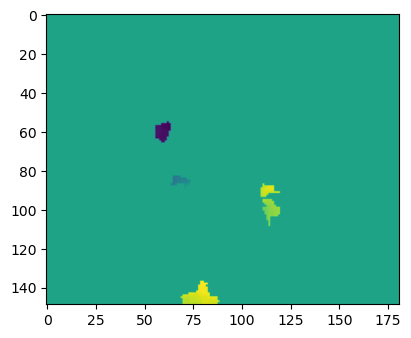

In [15]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

explainer = lime_image.LimeImageExplainer()

def predict_fn(data):
    proba_1 = model.predict(data)
    proba_0 = 1 - proba_1
    return np.hstack([proba_0, proba_1])

segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2, convert2lab=False)
explanation = explainer.explain_instance(X_test[5], predict_fn, 
                                         top_labels=2,
                                         hide_color=0, 
                                         num_samples=1000,
                                         segmentation_fn=segmenter)

print(predict_fn(X_test[0:1]))

temp, mask = explanation.get_image_and_mask(1, positive_only=True, num_features=5, hide_rest=True)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(temp)

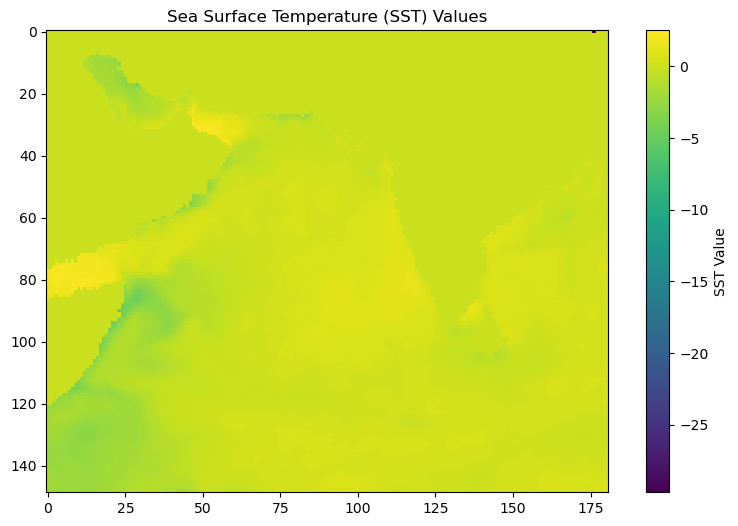

In [14]:
sst_values = X_test[0]

# Plotting
plt.figure(figsize=(10,6))
plt.imshow(sst_values, cmap='viridis')
plt.colorbar(label='SST Value')
plt.title('Sea Surface Temperature (SST) Values')
plt.show()

In [16]:
model.save("2D_checkpoint.keras")

In [22]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 [==============================] - 0s 35ms/step


array([[0.00117638]], dtype=float32)

In [20]:
X_test[0].shape

(149, 181, 1)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 149, 181, 1)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 149, 181, 1)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 149, 181, 1)          3         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 151, 183, 1)          0         ['normalization[0][0]']   

In [77]:
from PIL import Image
import numpy as np

def preprocess_and_predict(npy_path, model, target_shape=(149, 181)):
    # Load data from the .npy file
    image_array = np.load(npy_path)
    # Ensure the shape matches target shape (optional, but can be useful for sanity check)
    assert image_array.shape == target_shape, "Data shape mismatch!"
    
    # Normalize the image by subtracting its mean
    mean_val = np.nanmean(image_array)
    normalized_image = image_array - mean_val
 
    # If there are any NaN values, replace them with 0
    normalized_image = np.nan_to_num(normalized_image)
    
    # Adjust dimensions of the image to match model's expected input shape
    preprocessed_image = normalized_image[np.newaxis, :, :, np.newaxis]  # Adds a batch dimension and a channel dimension

    # Use the model to predict upwelling
    prediction = model.predict(preprocessed_image)
    return prediction[0][0]

# Updated path to the .npy file
npy_path = "/home/jovyan/shared/jiarui-notebooks/2018-02-15.npy"
prediction = preprocess_and_predict(npy_path, model)
print(prediction)


2.6869507
(1, 149, 181, 1)
0.375
1/1 [==============================] - 0s 35ms/step
0.004171565


In [31]:
data = []  # List to store each row of the DataFrame

# Iterate through all dates in date_to_data_map
for date, day_data in data_map.items():
    actual_val = filtered_labels[date]
        
    # Pre-process the day data and predict
    day_data = np.nan_to_num(day_data, nan=0.0)  # Replace NaN with 0
    day_data = np.expand_dims(day_data, axis=(0, -1))  # Add a new dimension for the batch and channel

    prediction = model.predict(day_data, verbose=0)

    # Append the data for the current date to the list
    data.append({'time': date, 'actual_val': actual_val, 'predicted_val': prediction[0][0]})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Check the DataFrame
print(df)

           time  actual_val  predicted_val
0    2000-01-01           0       0.003304
1    2000-01-02           0       0.003192
2    2000-01-03           0       0.003175
3    2000-01-04           0       0.003165
4    2000-01-05           0       0.003187
...         ...         ...            ...
7519 2020-12-27           0       0.003391
7520 2020-12-28           0       0.003284
7521 2020-12-29           0       0.003400
7522 2020-12-30           0       0.003920
7523 2020-12-31           0       0.004446

[7524 rows x 3 columns]


In [32]:
print(len(df[(df['actual_val'] == 0) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 0)]))
print(len(df[(df['actual_val'] == 1) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 1)]))

42
6644
857
880


/tmp/ipykernel_5415/2030461022.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
/tmp/ipykernel_5415/2030461022.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 

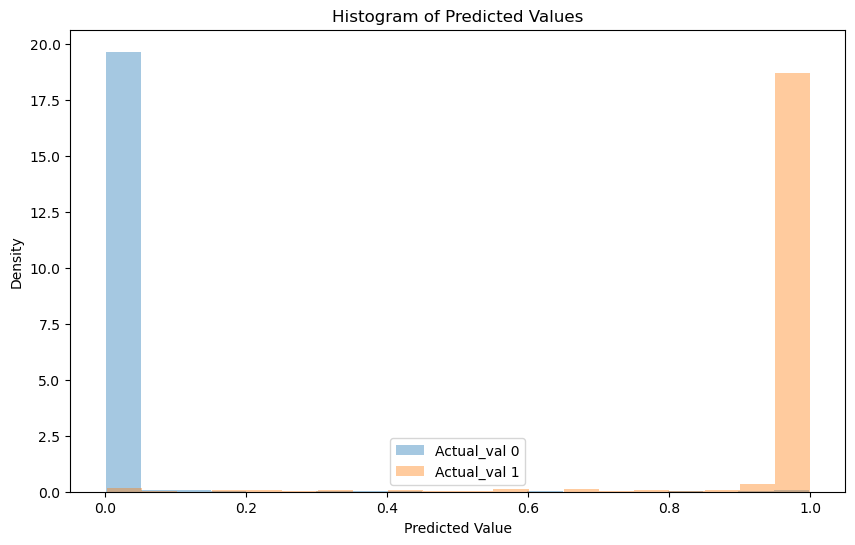

In [33]:
# Convert 'predicted_val' to float
df['predicted_val'] = df['predicted_val'].apply(lambda x: float(x[0]) if isinstance(x, (list, np.ndarray)) else float(x))

# Separate the data into two groups based on 'actual_val'
group0 = df[df['actual_val'] == 0]['predicted_val']
group1 = df[df['actual_val'] == 1]['predicted_val']

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')

# Set the labels and title
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('Histogram of Predicted Values')
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_5415/2049830768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['month'] = filtered_df['time'].dt.month


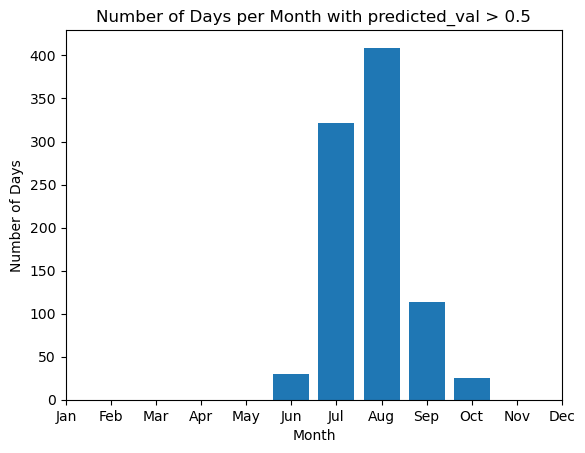

In [34]:
# Filter the DataFrame based on the condition
filtered_df = df[df['predicted_val'] > 0.5]

# Extract the month from the 'time' column
filtered_df['month'] = filtered_df['time'].dt.month

# Count the occurrences for each month
month_counts = filtered_df['month'].value_counts().sort_index()

# Plot the histogram
plt.bar(month_counts.index, month_counts.values)
plt.xlabel('Month')
plt.ylabel('Number of Days')
plt.title('Number of Days per Month with predicted_val > 0.5')
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

,time,actual_val,predicted_val
6502,2018-02-15,0,0.004172


In [64]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 149, 181, 1)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 149, 181, 1)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 149, 181, 1)          3         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 151, 183, 1)          0         ['normalization[0][0]']   